# Data Import

In [1]:
import pandas as pd

# fMRI data
TRAIN_FMRI_PATH = "data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_fmri_df = pd.read_csv(TRAIN_FMRI_PATH)

# Solutions
TRAIN_SOLUTIONS_PATH = "data/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_solutions_df = pd.read_excel(TRAIN_SOLUTIONS_PATH)

# Principal Component Analysis

Reduced to 1188 principal components


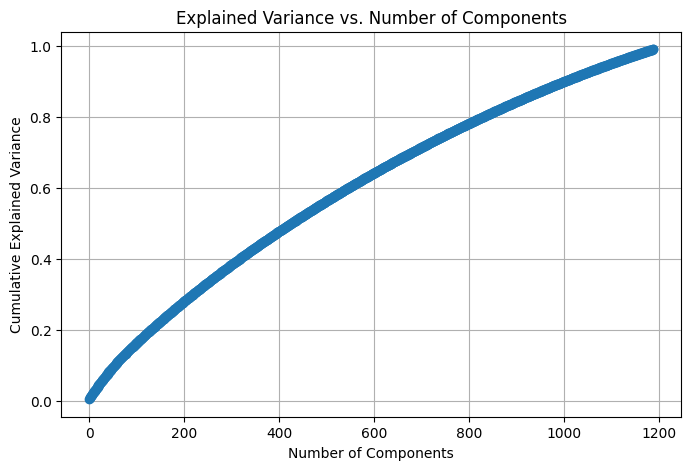

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract activation data (excluding participant ID)
X = train_fmri_df.iloc[:, 1:].values  # Shape (n_samples, 19900)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.99)  # Retain 99% of variance
X_pca = pca.fit_transform(X)  # Shape: (n_samples, reduced_dim)

# Print number of components selected
print(f"Reduced to {X_pca.shape[1]} principal components")

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

In [3]:
# Based on: https://stackoverflow.com/a/56722874/11620221
# Number of components
num_components = pca.components_.shape[0]

# Get the index of the most important feature 
# on EACH component i.e. largest absolute value
most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_components)]

initial_feature_names = train_fmri_df.columns[1:]

# get the names
most_important_col_names = [initial_feature_names[most_important[i]] for i in range(num_components)]
most_important_col_names[:5]

['26throw_129thcolumn',
 '52throw_53thcolumn',
 '37throw_60thcolumn',
 '30throw_56thcolumn',
 '159throw_177thcolumn']

In [4]:
# Select only the most important features
train_fmri_pca_df = train_fmri_df.loc[:, ["participant_id", *most_important_col_names]]
train_merged_df = pd.merge(train_fmri_pca_df, train_solutions_df, on="participant_id")
train_merged_df.head()

,participant_id,26throw_129thcolumn,52throw_53thcolumn,37throw_60thcolumn,30throw_56thcolumn,159throw_177thcolumn,55throw_143thcolumn,30throw_56thcolumn,159throw_177thcolumn,159throw_177thcolumn,...,126throw_143thcolumn,63throw_81thcolumn,156throw_157thcolumn,48throw_53thcolumn,65throw_121thcolumn,115throw_120thcolumn,84throw_126thcolumn,97throw_199thcolumn,ADHD_Outcome,Sex_F
0,70z8Q2xdTXM3,0.349598,0.065042,0.078589,0.100893,0.097534,-0.002699,0.100893,0.097534,0.097534,...,0.000398,-0.005401,0.123696,0.007718,0.066221,-0.040922,-0.000756,-0.008825,1,0
1,WHWymJu6zNZi,0.259638,0.090179,0.097306,0.009235,0.096187,0.106966,0.009235,0.096187,0.096187,...,0.052466,0.054743,0.121287,0.116589,-0.055189,-0.009365,0.008308,0.047154,1,1
2,4PAQp1M6EyAo,0.303860,0.184451,0.085065,0.058028,0.168140,-0.115081,0.058028,0.168140,0.168140,...,-0.012986,-0.012389,0.178881,-0.037068,-0.027588,-0.031097,0.027157,0.037536,1,1
3,obEacy4Of68I,0.389321,0.104383,0.009456,0.043865,0.092191,0.025773,0.043865,0.092191,0.092191,...,0.026352,-0.014083,0.094660,-0.039383,-0.055170,-0.000161,-0.017165,-0.006132,1,1
4,s7WzzDcmDOhF,0.266398,-0.038770,0.024310,0.057100,-0.016659,0.072332,0.057100,-0.016659,-0.016659,...,-0.018014,0.045447,0.092770,0.002342,-0.042209,0.052350,-0.057127,-0.027914,1,1


# Model Selection

In [5]:
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

# Custom loss function to account for class imbalance
def weighted_binary_crossentropy(y_true, y_pred, weight_0, weight_1):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

    loss = -(
        weight_0 * (1 - y_true) * K.log(1 - y_pred) + weight_1 * y_true * K.log(y_pred)
    )

    return K.mean(loss)


# Compute class weights
adhd_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_solutions_df.iloc[:, 1])
sex_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=train_solutions_df.iloc[:, 2])

adhd_loss = lambda y_true, y_pred: weighted_binary_crossentropy(
    y_true, y_pred, weight_0=adhd_weights[0], weight_1=adhd_weights[1]
)
sex_loss = lambda y_true, y_pred: weighted_binary_crossentropy(
    y_true, y_pred, weight_0=sex_weights[0], weight_1=sex_weights[1]
)

In [6]:
from tensorflow.keras import layers, Input, optimizers, metrics
from tensorflow.keras.models import Model


def create_hypermodel(hp):
    # MRI Input Branch (num_components features)
    mri_input = Input(shape=(num_components,), name="mri_input")
    x1 = mri_input

    # Add multiple dense layers with hyperparameter tuning
    for i in range(hp.Int("num_mri_layers", 1, 3)):
        x1 = layers.Dense(
            units=hp.Int(
                f"mri_units_{i}", min_value=16, max_value=int(num_components / 2), step=32
            ),
            activation="relu",
        )(x1)

    # Add a final Dense layer with two units and
    # sigmoid activation for binary classification
    # (1 = ADHD, 0 = No ADHD / 1 = Female, 0 = Male)
    output_adhd = layers.Dense(1, activation="sigmoid", name="adhd_output")(x1)
    output_sex = layers.Dense(1, activation="sigmoid", name="sex_output")(x1)

    # Compile the model with:
    # - binary cross-entropy loss
    # - SGD optimizer
    # - accuracy metric
    model = Model(inputs=mri_input, outputs=[output_adhd, output_sex])
    model.compile(
        loss={
            "adhd_output": adhd_loss,
            "sex_output": sex_loss,
        },
        metrics={
            "adhd_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
                metrics.Precision(name="precision"),
                metrics.Recall(name="recall"),
            ],
            "sex_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
                metrics.Precision(name="precision"),
                metrics.Recall(name="recall"),
            ],
        },
        optimizer=optimizers.legacy.Adam(learning_rate=0.001),
    )

    return model

# Model Training & Evaluation

In [7]:
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import KFold

MAX_EPOCHS = 50


def model_eval(X_mri, targets):
    # Initialize the RandomSearch tuner
    # for hyperparameter search based on Area Under Curve
    tuner = kt.RandomSearch(
        create_hypermodel,
        objective=[
            kt.Objective("val_adhd_output_pr_auc", direction="max"),
            kt.Objective("val_sex_output_pr_auc", direction="max"),
        ],
        directory="archive",
        project_name="bayes",
        overwrite=True,
    )

    # K-fold Cross Validation fold counter
    fold_no = 1

    # Define per-fold score containers
    loss_per_fold = []
    auc_per_fold = []

    # Initialize K-fold cross-validation with 3 splits
    kfolder = KFold(n_splits=3, shuffle=True, random_state=42)

    # Go through each fold
    for train, val in kfolder.split(X_mri, targets):
        # Get the training data
        input_vectors = X_mri[train]
        y_train = targets[train]
        y_train_vectors = [y_train[:, 0], y_train[:, 1]]

        # Perform hyperparameter search with Keras Tuner
        tuner.search(
            input_vectors,
            y_train_vectors,
            validation_split=0.2,
            verbose=False,
        )

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters()[0]

        # Build the model with the optimal hyperparameters and train it
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            input_vectors,
            y_train_vectors,
            epochs=MAX_EPOCHS,
            validation_split=0.2,
            verbose=False,
        )

        # Find the best epoch based on validation auc
        val_auc_adhd_per_epoch = history.history["val_adhd_output_pr_auc"]
        val_auc_sex_per_epoch = history.history["val_sex_output_pr_auc"]
        best_epoch = int(
            (
                val_auc_adhd_per_epoch.index(max(val_auc_adhd_per_epoch))
                + val_auc_sex_per_epoch.index(max(val_auc_sex_per_epoch))
                + 2
            )
            / 2
        )

        # Retrain the model on the best hyperparameters and epoch
        hypermodel = tuner.hypermodel.build(best_hps)
        hypermodel.fit(
            input_vectors,
            y_train_vectors,
            epochs=best_epoch,
            validation_split=0.2,
            verbose=False,
        )

        # Vectorize the validation data
        input_vectors_val = X_mri[val]
        y_val = targets[val]
        y_val_vectors = [y_val[:, 0], y_val[:, 1]]

        # Evaluate the model on the validation data
        (
            loss,
            adhd_output_loss,
            sex_output_loss,
            adhd_output_roc_auc,
            adhd_output_pr_auc,
            adhd_output_precision,
            adhd_output_recall,
            sex_output_roc_auc,
            sex_output_pr_auc,
            sex_output_precision,
            sex_output_recall,
        ) = hypermodel.evaluate(input_vectors_val, y_val_vectors, verbose=False)

        loss_per_fold.append(loss)
        auc_per_fold.append((adhd_output_pr_auc + sex_output_pr_auc) / 2)

        # Increase fold number
        fold_no = fold_no + 1

    # Return the best hyperparameters and their
    # corresponding F1 and loss metrics
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    hp_data = {
        "loss": round(np.mean(loss_per_fold), 3),
        "auc": round(np.mean(auc_per_fold), 3),
        "num_mri_layers": best_hps.values["num_mri_layers"],
    }

    # Capture the best model's structure
    # Track the sequence of layer(s)
    # and their no. of units
    mri_units = []

    # Iterate over num_mri_layers
    for i in range(best_hps.values["num_mri_layers"]):
        try:
            # Track no. of mri layers and units
            if best_hps.values[f"mri_units_{i}"]:
                num_mri_units = best_hps.values[f"mri_units_{i}"]

                # Save the number of units per
                # layer in the correct sequence
                mri_units.append(str(num_mri_units))

        except:
            pass

    # Store in hp_data for return
    hp_data["mri_units"] = mri_units

    return hp_data

Using TensorFlow backend


In [8]:
def find_best_model(tries, X_mri, y_train):
    # Track metric & hyperparameter
    # information about the neural networks
    data = []

    for _ in range(tries):
        # Find and save the best neural network structure
        data.append(model_eval(X_mri, y_train))

    # Print a table summarizing the neural networks' structures
    print("Loss\t", "AUC\t", "Hidden Layers\t")

    max_auc_index = -1
    max_auc = 0

    for i in range(len(data)):
        hp_data = data[i]

        print(
            f"{hp_data['loss']}\t",
            f"{hp_data['auc']}\t",
            f"{' → '.join(hp_data['mri_units'])}\t",
        )

        if (hp_data["auc"] > max_auc):
            max_auc = hp_data["auc"]
            max_auc_index = i

    return data[max_auc_index]

In [9]:
# Try to find the best neural network structure, 10 times
X = train_merged_df.iloc[:, 1:-2].values  # 26throw_129thcolumn ... whatever column
y = train_merged_df.iloc[:, -2:].values.astype("float32")  # [ADHD_Outcome, Sex_F]

best_model_data = find_best_model(10, X.copy(), y.copy())

Loss	 AUC	 Hidden Layers	
3.035	 0.537	 144 → 80 → 16	
1.753	 0.539	 496	
1.494	 0.541	 528	
1.838	 0.545	 176	
2.474	 0.541	 144 → 144	
2.663	 0.543	 272 → 240	
3.385	 0.544	 528 → 240	
2.858	 0.552	 240 → 176 → 112	
2.492	 0.544	 336	
1.491	 0.531	 336 → 208 → 16	


# Predicting Labels and Performance Evaluation

In [10]:
from sklearn.model_selection import train_test_split
from keras import callbacks


def create_model(num_mri_layers):
    # MRI Input Branch (num_components features)
    mri_input = Input(shape=(num_components,), name="mri_input")
    x1 = mri_input

    # Add multiple dense layers with hyperparameter tuning
    for i in range(len(num_mri_layers)):
        x1 = layers.Dense(
            units=int(num_mri_layers[i]),
            activation="relu",
        )(x1)

    # Add a final Dense layer with two units and
    # sigmoid activation for binary classification
    # (1 = ADHD, 0 = No ADHD / 1 = Female, 0 = Male)
    output_adhd = layers.Dense(1, activation="sigmoid", name="adhd_output")(x1)
    output_sex = layers.Dense(1, activation="sigmoid", name="sex_output")(x1)

    # Compile the model with:
    # - binary cross-entropy loss
    # - SGD optimizer
    # - accuracy metric
    model = Model(inputs=mri_input, outputs=[output_adhd, output_sex])
    model.compile(
        loss={
            "adhd_output": adhd_loss,
            "sex_output": sex_loss,
        },
        metrics={
            "adhd_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
                metrics.Precision(name="precision"),
                metrics.Recall(name="recall"),
            ],
            "sex_output": [
                metrics.AUC(name="roc_auc"),
                metrics.AUC(name="pr_auc", curve="PR"),
                metrics.Precision(name="precision"),
                metrics.Recall(name="recall"),
            ],
        },
        optimizer=optimizers.legacy.Adam(learning_rate=0.001),
    )

    return model


# Re-create the model from the best hyperparameters
best_model = create_model(best_model_data["mri_units"])

# Train-test split on our training dataset (1213 rows)
X_mri_train, X_mri_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
best_model.fit(
    X_mri_train,
    [y_train[:, 0], y_train[:, 1]],
    callbacks=[callbacks.EarlyStopping(monitor="loss", patience=0)],
    verbose=False,
)

# Predict classes
y_pred = best_model.predict(X_mri_test)
y_pred

8/8 [==============================] - 0s 822us/step


[array([[0.52699655],
        [0.49144903],
        [0.53935844],
        [0.49294758],
        [0.50184405],
        [0.5186375 ],
        [0.56370485],
        [0.5419937 ],
        [0.5416751 ],
        [0.51859117],
        [0.5096601 ],
        [0.49224138],
        [0.47667554],
        [0.5300652 ],
        [0.5047166 ],
        [0.53132325],
        [0.53046244],
        [0.5319797 ],
        [0.5055827 ],
        [0.5164552 ],
        [0.5302954 ],
        [0.50388014],
        [0.5130791 ],
        [0.53203785],
        [0.5376736 ],
        [0.5355031 ],
        [0.5056737 ],
        [0.49983415],
        [0.5458662 ],
        [0.4917699 ],
        [0.5175455 ],
        [0.49508893],
        [0.51829416],
        [0.51600945],
        [0.51914006],
        [0.5137926 ],
        [0.5148445 ],
        [0.5300057 ],
        [0.5054966 ],
        [0.54417545],
        [0.54841995],
        [0.4982645 ],
        [0.50034094],
        [0.50244325],
        [0.518117  ],
        [0

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Evaluate the best model on the test set
y_test_vector = [y_test[:, 0], y_test[:, 1]]
converted_y_pred = [(np.array(y_pred[0]) >= 0.5).astype(int), (np.array(y_pred[1]) >= 0.5).astype(int)]

# Calculate ROC-AUC score for each output
roc_auc_adhd = roc_auc_score(y_test_vector[0], converted_y_pred[0])
roc_auc_sex = roc_auc_score(y_test_vector[1], converted_y_pred[1])

# Report the ROC-AUC score on the test set
print("ROC-AUC Score on Test Set (ADHD):", roc_auc_adhd)
print("ROC-AUC Score on Test Set (Sex):", roc_auc_sex)

# Calculate accuracy for each output
accuracy_adhd = accuracy_score(y_test_vector[0], converted_y_pred[0])
accuracy_sex = accuracy_score(y_test_vector[1], converted_y_pred[1])

# Report the accuracy on the test set
print("Accuracy Score on Test Set (ADHD):", accuracy_adhd)
print("Accuracy Score on Test Set (Sex):", accuracy_sex)

# Print classification report for each output
print("")
print("Classification Report (ADHD):")
print(classification_report(y_test_vector[0], converted_y_pred[0], zero_division=True))
print("Classification Report (Sex):")
print(classification_report(y_test_vector[1], converted_y_pred[1], zero_division=True))

ROC-AUC Score on Test Set (ADHD): 0.43128654970760233
ROC-AUC Score on Test Set (Sex): 0.5127450980392156
Accuracy Score on Test Set (ADHD): 0.5843621399176955
Accuracy Score on Test Set (Sex): 0.6255144032921811

Classification Report (ADHD):
              precision    recall  f1-score   support

         0.0       0.11      0.06      0.07        72
         1.0       0.67      0.81      0.73       171

    accuracy                           0.58       243
   macro avg       0.39      0.43      0.40       243
weighted avg       0.50      0.58      0.54       243

Classification Report (Sex):
              precision    recall  f1-score   support

         0.0       0.64      0.95      0.76       153
         1.0       0.47      0.08      0.13        90

    accuracy                           0.63       243
   macro avg       0.55      0.51      0.45       243
weighted avg       0.57      0.63      0.53       243

